# Import the Data and Split Into Test and Training Sets

In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

%matplotlib inline

n_mult=1
noise_level=.05

directory= './Data/Local Sensitivity/'
# directory= './Data/Local Sensitivity Expanded/'
# directory = './Data/Global Sensitivity/'
runs = []
for filename in os.listdir(directory):
    if filename.startswith('gen'):
        run = int(filename.split('_')[2].split('.')[0])
        runs.append(run)
       
count=0

# set up the Pandas Dataframes
volts=pd.DataFrame(columns=range(255),dtype=np.float64)
times=pd.DataFrame(columns=range(255),dtype=np.float64)
vals=pd.DataFrame(columns=range(41),dtype=np.float64)
temp1=[]
temp2=[]
temp3=[]
names=[]
count=0
# Iterate through the files
for run in sorted(runs):
    count=count+1
    if True:
        filename = '/gen_data_' + str(run) + '.csv'
        data = pd.read_csv(directory + filename, sep=',')
        temp1=[]
        temp2=[]
        temp3=[]
        # parse the data
        for column in data.columns:
            if column.find('olts')>0:
                temp1=np.concatenate((temp1,data[column].tolist()))
            if column.find('ime')>0:
                temp3=np.concatenate((temp3,data[column].tolist()))
            if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
                if data[column][0]!=0:
                    temp2.append(data[column][0])
        volts.loc[run,:]=temp1
        vals.loc[run,:]=temp2
        times.loc[run,:]=temp3


for column in data.columns:
    if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
        if data[column][0]!=0:
            names.append(column) 

# Split the data into 'test' and 'training' sets
train = sorted(random.sample(range(volts.shape[0]), int(volts.shape[0]*(3.0/4))))
test = [x for x in range(volts.shape[0]) if x not in train]
P=vals
P_mean = P.mean()
P_std = P.std()

# Normalize the data
P = (P - P.mean())/P.std()

times_train=times.iloc[train,:]
Z_train = volts.iloc[train,:]
P_train = P.iloc[train,:]

times_test = times.iloc[test,:]
Z_test = volts.iloc[test,:]
P_test = P.iloc[test,:]

X_train = pd.DataFrame()
Y_train = pd.DataFrame()

X_train_noise = pd.DataFrame()
X_test_noise = pd.DataFrame()

X_test = pd.DataFrame()
Y_test = pd.DataFrame()

# Add noise and possibly duplicate
for _ in range(n_mult):
                      
    X_test_noise = pd.concat((X_test, Z_test + np.random.randn(Z_test.shape[0],Z_test.shape[1])*noise_level))
    X_train_noise = pd.concat((X_train, Z_train + np.random.randn(Z_train.shape[0],Z_train.shape[1])*noise_level))
    
    Y_train = pd.concat((Y_train, P_train))
    X_train = pd.concat((X_train, Z_train))
    
    X_test = pd.concat((X_test, Z_test))  
    Y_test = pd.concat((Y_test, P_test))

times_train=np.array(times_train)    
X_train_noise = np.array(X_train_noise)
X_train = np.array(X_train)
Y_train = np.array(Y_train)


times_test=np.array(times_test)
X_test_noise = np.array(X_test_noise)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


YY_train = Y_train
XX_train = X_train
print('done')

X_full = np.array(volts)
Y_full = np.array(vals)
print(count)

done
406


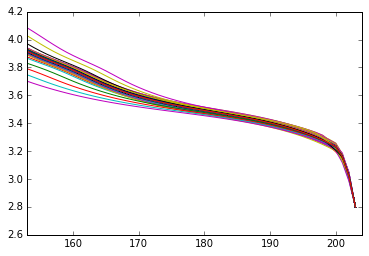

In [6]:
y_1=[]
for i in range(153,204):
    y_1.append(i)
for i in range(len(X_train)):
    plt.plot(y_1,X_train[i][153:204])
#     plt.plot(y_1,X_train_noise[i][153:204])

plt.xlim(153,204)
plt.show()

In [3]:
# Running different Regression methods
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

import time
print("extra trees")
start_time = time.time()
etr = ExtraTreesRegressor(n_estimators=200, n_jobs=-1,max_depth=22)
etr.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', etr.score(X_test,Y_test), 'Train:', etr.score(X_train,Y_train))
start_time = time.time()

print("KNN")
start_time = time.time()
knn = KNeighborsRegressor(n_neighbors=40,weights = 'distance')
knn.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', knn.score(X_test,Y_test), 'Train:', knn.score(X_train,Y_train))

print("linear")
start_time = time.time()
lin = linear_model.LinearRegression()
lin.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', lin.score(X_test,Y_test), 'Train:', lin.score(X_train,Y_train))


extra trees
--- 1.93300008774 seconds ---
('Test:', -0.029824631334624721, 'Train:', 0.40403803326737925)
KNN
--- 0.00600004196167 seconds ---
('Test:', -0.054099643045576185, 'Train:', 0.38534461932930886)
linear
--- 0.0410001277924 seconds ---
('Test:', -1.196990877980613e+25, 'Train:', 0.38294227960452765)


In [5]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

Grid scores on development set:

0.986 (+/-0.016) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.959 (+/-0.029) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.982 (+/-0.026) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 10}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 100}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model 

### Learn about Hyperparameters

In [5]:
#list hyperparameters
etr.get_params()

{'bootstrap': False,
 'criterion': 'mse',
 'max_depth': 22,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Visualizing the Data
## How do the different types of algorithms compare?

56


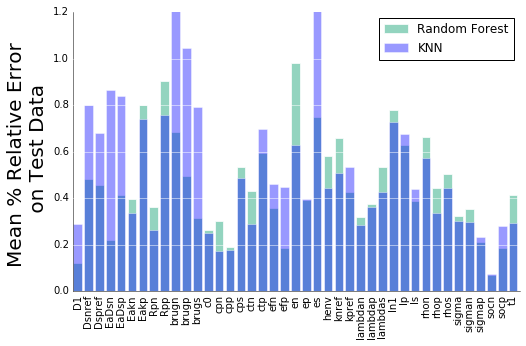

In [4]:
### plot all 3 on the same chart
import prettyplotlib as ppl
print len(data.columns)
a = []
aa = []
aaa = []

predicted1 = etr.predict(X_test)
predicted2 = knn.predict(X_test)
predicted3 = lin.predict(X_test)
for j in range(Y_test.shape[1]):
    re = []
    for i in range(len(Y_test)):
        predicted = predicted1[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    a.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted2[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aa.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted3[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaa.append(re)
    
results1 = np.array(a)
means1 = np.ndarray(shape=(P.shape[1],))
stds1 = np.ndarray(shape=(P.shape[1],))
results2 = np.array(aa)
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))
results3 = np.array(aaa)
means3 = np.ndarray(shape=(P.shape[1],))
stds3 = np.ndarray(shape=(P.shape[1],))


for p in range(results1.shape[0]):
    mean1 = results1[p].mean()
    std1 = results1[p].std()
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    mean3 = results3[p].mean()
    std3 = results3[p].std()
    
    means1[p] = mean1
    stds1[p] = std1/np.sqrt(results1.shape[1])
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])
    means3[p] = mean3
    stds3[p] = std3/np.sqrt(results3.shape[1])
fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results1.shape[0]), means1*100,
        xticklabels=names, grid='y', alpha=0.7,label='Random Forest') # etr
ppl.bar(range(results2.shape[0]), means2*100, 
        grid='y', color='b', alpha=0.4,label='KNN') # knn
# ppl.bar(range(results3.shape[0]), means3*100,
#         grid='y', color='r', alpha=0.1, label='Linear') # lin
plt.ylim(0,1.2)
plt.legend()
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.xlim(0,41)
plt.show()

### How long does it take to predict?

In [24]:
import time
temp5 = X_test[1].reshape(1,-1)
st=time.time()
temp4=etr.predict(temp5)
print "prediction time:", (time.time()-st)
print (temp4-Y_test[1])*100

prediction time: 0.220999956131
[[  5.53889898e+02   1.76408246e-04  -2.92203163e-04   6.43070691e-03
   -1.57649409e+01   8.21205278e-03  -1.28362599e-02   8.67361738e-16
    1.60461922e-15   3.47106492e+00   6.75450472e+00  -2.34531414e+00
    2.88232381e-02   2.30554555e-02  -1.43949995e-02  -1.01657900e-02
    9.88792381e-15  -1.12757026e-15   5.78974581e-05   8.76609488e-04
    6.93889390e-16  -3.03576608e-15   5.81637906e+00  -3.15071833e-02
   -2.49366500e-16  -2.60208521e-16   1.79011877e-02  -1.10993361e-02
    1.34601522e-03   6.59194921e-15  -3.81639165e-15   2.13548687e-02
    1.32859642e-02  -2.05766451e-02  -8.98178849e-03   2.06547091e-02
   -4.66773086e-04  -3.15071833e-03  -2.77555756e-15   1.95156391e-15
    2.06129820e-02]]


# What about giving each variable its own Random Forest?

In [19]:
from sklearn.ensemble import ExtraTreesRegressor
aaaa = []
for j in range(P.shape[1]):
    Y_temp = np.zeros((len(YY_train),))
    Y_temp2 = np.zeros((len(Y_test),))

    for i in range(len(Y_test)):
        Y_temp2[i]=Y_test[i][j]
    start_time = time.time()
    etr7 = ExtraTreesRegressor(n_estimators=200, n_jobs=-1)
    etr7.fit(X_train,Y_temp)
    print names[j], "Test score:", etr7.score(X_test,Y_temp2)
    predicted3 = etr7.predict(X_test)
    re = []
    for i in range(len(Y_test)):
        predicted = predicted3[i]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaaa.append(re)

D1 Test score: -0.000638224938475
Dsnref Test score: -0.000661999813548
Dspref Test score: -0.00106256252017
EaDsn Test score: -0.00115137125916
EaDsp Test score: -2.67686319646e-05
Eakn Test score: -0.00173028704587
Eakp Test score: -3.47259580891e-06
Rpn Test score: -0.00242546027788
Rpp Test score: -0.000483890045183
brugn Test score: -0.000770472555876
brugp Test score: -7.36485105397e-05
brugs Test score: -0.000407148288509
c0 Test score: -0.00141391335039
cpn Test score: -0.00217249774878
cpp Test score: -0.000145260925075
cps Test score: -0.000278833984904
ctn Test score: -0.00455611501894
ctp Test score: -0.000199821536943
efn Test score: -0.00174760288873
efp Test score: -4.10922300087e-05
en Test score: -0.00317797283589
ep Test score: -0.00193377110892
es Test score: -0.000182047686253
henv Test score: -0.00016856620348
knref Test score: -3.17430132009e-05
kpref Test score: -0.000427174450996
lambdan Test score: -0.000841525284309
lambdap Test score: -2.47449274431e-05
lambd

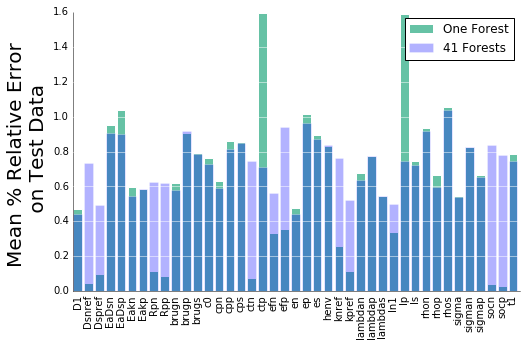

In [ ]:
results=np.array(a)
results2 = np.array(aaaa)
means = np.ndarray(shape=(P.shape[1],))
stds = np.ndarray(shape=(P.shape[1],))
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))

for p in range(results.shape[0]):
    mean = results[p].mean()
    std = results[p].std()
    
    means[p] = mean
    stds[p] = std/np.sqrt(results.shape[1])

for p in range(results2.shape[0]):  
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])
import prettyplotlib as ppl

fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results.shape[0]), means*100,
        xticklabels=names, grid='y', label='One Forest')
ppl.bar(range(results2.shape[0]), means2*100,
        xticklabels=names, grid='y', color='b', alpha=0.3, label='41 Forests')
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.legend()
plt.xlim(0,P.shape[1])
plt.show()


# Does adding noise degrade predictions?

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
aaaaa = []
for j in range(P.shape[1]):
    Y_temp = np.zeros((len(YY_train),))
#     Y_temp2 = np.zeros((len(Y_test),))
    for i in range(len(Y_test)):
        Y_temp2[i]=Y_test[i][j]
    start_time = time.time()
    etr8 = ExtraTreesRegressor(n_estimators=200, n_jobs=-1)
    etr8.fit(X_train_noise,Y_temp)
    print names[j], "Test score:", etr8.score(X_test_noise,Y_temp2)
    predicted3 = etr8.predict(X_test_noise)
    re = []
    for i in range(len(Y_test)):
        predicted = predicted3[i]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaaaa.append(re)

D1 Test score: -0.000638224938475
Dsnref Test score: -0.000661999813548
Dspref Test score: -0.00106256252017
EaDsn Test score: -0.00115137125916
EaDsp Test score: -2.67686319646e-05
Eakn Test score: -0.00173028704587
Eakp Test score: -3.47259580891e-06
Rpn Test score: -0.00242546027788
Rpp Test score: -0.000483890045183
brugn Test score: -0.000770472555876
brugp Test score: -7.36485105397e-05
brugs Test score: -0.000407148288509


In [ ]:
results1 = np.array(a)
results2 = np.array(aaaa)
results3 = np.array(aaaaa)
means = np.ndarray(shape=(P.shape[1],))
stds = np.ndarray(shape=(P.shape[1],))
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))
means3 = np.ndarray(shape=(P.shape[1],))
stds3 = np.ndarray(shape=(P.shape[1],))

for p in range(results1.shape[0]):
    mean = results1[p].mean()
    std = results1[p].std()
    
    means[p] = mean
    stds[p] = std/np.sqrt(results1.shape[1])

for p in range(results2.shape[0]):  
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])

for p in range(results3.shape[0]):  
    mean3 = results3[p].mean()
    std3 = results3[p].std()
    
    means3[p] = mean3
    stds3[p] = std3/np.sqrt(results3.shape[1])
import prettyplotlib as ppl

fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results1.shape[0]), means1*100,
        xticklabels=names, grid='y',label='One Forest')
ppl.bar(range(results2.shape[0]), means2*100,
        xticklabels=names, grid='y', color='b', alpha=0.4,label='No Noise')
ppl.bar(range(results3.shape[0]), means3*100,
        xticklabels=names, grid='y', color='r', alpha=0.1, label='Added Noise')
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.legend()
plt.xlim(0,P.shape[1])
plt.show()